In [70]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import tensorflow_addons as tfa
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
# from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from tensorflow.python.keras.preprocessing import dataset_utils
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization,MaxPooling2D
from tensorflow.python.client import device_lib
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from pathlib import Path

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0],True)
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [3]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [4]:
img_width, img_height = 150,150
batch_size = 10
epochs = 200
COUNT_NORMAL_TRAIN = 1342
COUNT_PNEUMONIA_TRAIN = 3876
TRAIN_IMAGE_COUNT = COUNT_NORMAL_TRAIN + COUNT_PNEUMONIA_TRAIN
weight_for_0 = (1 / COUNT_NORMAL_TRAIN ) * (TRAIN_IMAGE_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA_TRAIN) * (TRAIN_IMAGE_COUNT) / 2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [5]:
if K.image_data_format()=="channels_first":
    input_shape =(3,img_width, img_height)
else:
    input_shape =(img_width, img_height,3)


In [6]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./chest_xray/chest_xray/train/',
    labels='inferred',
    seed=123,
    validation_split=0.2,
    subset='training',
    batch_size=batch_size,
    image_size=(img_height,img_width)
)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.


In [7]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./chest_xray/chest_xray/train/',
    labels='inferred',
    seed=123,
    validation_split=0.2,
    subset='validation',
    batch_size=batch_size,
    image_size=(img_height,img_width)
)

Found 5216 files belonging to 2 classes.
Using 1043 files for validation.


In [8]:
class_names = train_dataset.class_names
class_names

['NORMAL', 'PNEUMONIA']

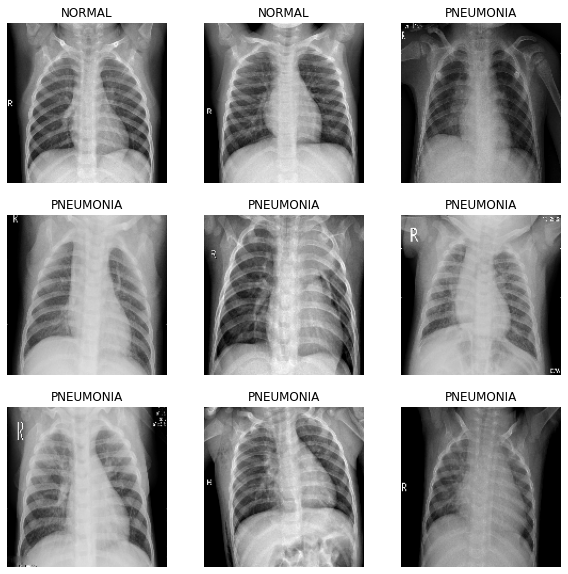

In [9]:
plt.figure(figsize=(10, 10))

for images,labels in train_dataset.take(3):
    for i in range (9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [10]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 150, 150, 3)
(10,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)


In [12]:
def build_model_densenet():
    model_densenet = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        classes=1
    )
    
    for layer in model_densenet.layers[:-8]:
        layer.trainable=False
        
    for layer in model_densenet.layers[-8:]:
        layer.trainable=True
    
    model = tf.keras.Sequential(
        [
            tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape),
            tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
            tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
            tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
            tf.keras.layers.experimental.preprocessing.RandomZoom(
                height_factor=0.2,
                width_factor=0.2,
            ),
            model_densenet,
            GlobalAveragePooling2D(),
            BatchNormalization(),
            Dropout(0.2),
            Dense(1024,activation='relu'),
            Dense(512,activation='relu'),
            BatchNormalization(),
            Dense(1,activation='sigmoid')
        ]
    )

    return model

In [13]:
def build_model_kaggle(): 
    model = Sequential(
#         [
#             tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape),
#             tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#             tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
#             tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2,width_factor=0.2),
#     #             tf.keras.layers.experimental.preprocessing.RandomTranslation(width_factor=0.2),
#             tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
#             tf.keras.layers.experimental.preprocessing.RandomWidth(factor=0.2),
#             tf.keras.layers.experimental.preprocessing.RandomHeight(factor=0.2),
#             tf.keras.layers.experimental.preprocessing.RandomZoom(
#                 height_factor=0.2,
#                 width_factor=0.2,
#             ),
#         ]
    )
#     model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
#     model.add(tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'))
#     model.add(tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'))
#     model.add(tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2,width_factor=0.2))
#     model.add(tf.keras.layers.experimental.preprocessing.RandomWidth(factor=0.2))
#     model.add(tf.keras.layers.experimental.preprocessing.RandomHeight(factor=0.2))
#     model.add(tf.keras.layers.experimental.preprocessing.RandomZoom(
#                 height_factor=0.2,
#                 width_factor=0.2,
#             ))
#     model.add(tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02))
#     model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
#     model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#     model.add(Dropout(0.1))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
#     model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
#     model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
#     model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
#     model.add(Flatten())
#     model.add(Dense(128 , activation = 'relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(1 , activation = 'sigmoid'))
#     model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

    model = Sequential()
    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Flatten())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'sigmoid'))
    model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
    model.summary()
    return model
#     model.summary()

In [14]:
model = build_model_densenet()
# model = build_model_kaggle()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 150, 150, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 150, 150, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 150, 150, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 150, 150, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0

In [15]:
# model = build_model_resNet50V2()
# model.summary()

In [16]:
def focal_loss_custom(alpha, gamma):
   def binary_focal_loss(y_true, y_pred):
      fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)
#       y_true_K = tf.ones_like(y_true)
      focal_loss = fl(tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32))
      return focal_loss
   return binary_focal_loss

In [17]:
# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.2, # Randomly zoom image 
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip = True,  # randomly flip images
#         vertical_flip=False)  # randomly flip images

# datagen.fit(train_dataset)

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [19]:
model.compile(
    optimizer='adam',
#     loss='binary_crossentropy',
#     loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=0.2,gamma=2.0),
    loss=focal_loss_custom(gamma=2.0,alpha=0.2),
    metrics=METRICS
)

In [20]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weight,
    callbacks = [learning_rate_reduction]
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/200
418/418 [==============================] - 31s 50ms/step - loss: 0.0726 - tp: 2104.0000 - fp: 73.0000 - tn: 1035.0000 - fn: 961.0000 - accuracy: 0.7522 - precision: 0.9665 - recall: 0.6865 - auc: 0.8912 - prc: 0.9570 - val_loss: 0.0286 - val_tp: 609.0000 - val_fp: 2.0000 - val_tn: 231.0000 - val_fn: 201.0000 - val_accuracy: 0.8054 - val_precision: 0.9967 - val_recall: 0.7519 - val_auc: 0.9799 - val_prc: 0.9941
Epoch 2/200
418/418 [==============================] - 18s 44ms/step - loss: 0.0311 - tp: 2267.0000 - fp: 40.0000 - tn: 1068.0000 - fn: 798.0000 - accuracy: 0.7992 - precision: 0.9827 - recall: 0.7396 - auc: 0.9440 - prc: 0.9792 - val_loss: 0.0449 - val_tp: 548.0000 - val_fp: 0.0000e+00 - val_tn: 233.0000 - val_fn: 262.0000 - val_accuracy: 0.7488 - val_precision: 1.0000 - val_recall: 0.6765 - val_auc: 0.9867 - val_prc: 0.9963
Epoch 

418/418 [==============================] - 19s 46ms/step - loss: 0.0157 - tp: 2623.0000 - fp: 18.0000 - tn: 1090.0000 - fn: 442.0000 - accuracy: 0.8898 - precision: 0.9932 - recall: 0.8558 - auc: 0.9844 - prc: 0.9944 - val_loss: 0.0224 - val_tp: 632.0000 - val_fp: 0.0000e+00 - val_tn: 233.0000 - val_fn: 178.0000 - val_accuracy: 0.8293 - val_precision: 1.0000 - val_recall: 0.7802 - val_auc: 0.9940 - val_prc: 0.9983
Epoch 38/200
418/418 [==============================] - 19s 46ms/step - loss: 0.0150 - tp: 2616.0000 - fp: 12.0000 - tn: 1096.0000 - fn: 449.0000 - accuracy: 0.8895 - precision: 0.9954 - recall: 0.8535 - auc: 0.9854 - prc: 0.9949 - val_loss: 0.0233 - val_tp: 626.0000 - val_fp: 0.0000e+00 - val_tn: 233.0000 - val_fn: 184.0000 - val_accuracy: 0.8236 - val_precision: 1.0000 - val_recall: 0.7728 - val_auc: 0.9940 - val_prc: 0.9983
Epoch 39/200
418/418 [==============================] - 19s 45ms/step - loss: 0.0157 - tp: 2600.0000 - fp: 14.0000 - tn: 1094.0000 - fn: 465.0000 - acc

418/418 [==============================] - 19s 44ms/step - loss: 0.0150 - tp: 2654.0000 - fp: 17.0000 - tn: 1091.0000 - fn: 411.0000 - accuracy: 0.8974 - precision: 0.9936 - recall: 0.8659 - auc: 0.9868 - prc: 0.9951 - val_loss: 0.0233 - val_tp: 625.0000 - val_fp: 0.0000e+00 - val_tn: 233.0000 - val_fn: 185.0000 - val_accuracy: 0.8226 - val_precision: 1.0000 - val_recall: 0.7716 - val_auc: 0.9942 - val_prc: 0.9983
Epoch 76/200
418/418 [==============================] - 18s 44ms/step - loss: 0.0138 - tp: 2644.0000 - fp: 12.0000 - tn: 1096.0000 - fn: 421.0000 - accuracy: 0.8962 - precision: 0.9955 - recall: 0.8626 - auc: 0.9884 - prc: 0.9959 - val_loss: 0.0230 - val_tp: 629.0000 - val_fp: 0.0000e+00 - val_tn: 233.0000 - val_fn: 181.0000 - val_accuracy: 0.8265 - val_precision: 1.0000 - val_recall: 0.7765 - val_auc: 0.9941 - val_prc: 0.9983
Epoch 77/200
418/418 [==============================] - 19s 44ms/step - loss: 0.0139 - tp: 2644.0000 - fp: 13.0000 - tn: 1095.0000 - fn: 421.0000 - acc

418/418 [==============================] - 19s 45ms/step - loss: 0.0140 - tp: 2658.0000 - fp: 13.0000 - tn: 1095.0000 - fn: 407.0000 - accuracy: 0.8994 - precision: 0.9951 - recall: 0.8672 - auc: 0.9868 - prc: 0.9955 - val_loss: 0.0229 - val_tp: 632.0000 - val_fp: 0.0000e+00 - val_tn: 233.0000 - val_fn: 178.0000 - val_accuracy: 0.8293 - val_precision: 1.0000 - val_recall: 0.7802 - val_auc: 0.9945 - val_prc: 0.9984
Epoch 114/200
418/418 [==============================] - 19s 45ms/step - loss: 0.0148 - tp: 2636.0000 - fp: 20.0000 - tn: 1088.0000 - fn: 429.0000 - accuracy: 0.8924 - precision: 0.9925 - recall: 0.8600 - auc: 0.9858 - prc: 0.9950 - val_loss: 0.0233 - val_tp: 627.0000 - val_fp: 0.0000e+00 - val_tn: 233.0000 - val_fn: 183.0000 - val_accuracy: 0.8245 - val_precision: 1.0000 - val_recall: 0.7741 - val_auc: 0.9944 - val_prc: 0.9984
Epoch 115/200
418/418 [==============================] - 19s 44ms/step - loss: 0.0135 - tp: 2666.0000 - fp: 11.0000 - tn: 1097.0000 - fn: 399.0000 - a

Epoch 132/200
418/418 [==============================] - 19s 45ms/step - loss: 0.0153 - tp: 2663.0000 - fp: 19.0000 - tn: 1089.0000 - fn: 402.0000 - accuracy: 0.8991 - precision: 0.9929 - recall: 0.8688 - auc: 0.9851 - prc: 0.9946 - val_loss: 0.0221 - val_tp: 640.0000 - val_fp: 0.0000e+00 - val_tn: 233.0000 - val_fn: 170.0000 - val_accuracy: 0.8370 - val_precision: 1.0000 - val_recall: 0.7901 - val_auc: 0.9941 - val_prc: 0.9983
Epoch 133/200
418/418 [==============================] - 19s 44ms/step - loss: 0.0154 - tp: 2656.0000 - fp: 11.0000 - tn: 1097.0000 - fn: 409.0000 - accuracy: 0.8994 - precision: 0.9959 - recall: 0.8666 - auc: 0.9858 - prc: 0.9946 - val_loss: 0.0220 - val_tp: 638.0000 - val_fp: 0.0000e+00 - val_tn: 233.0000 - val_fn: 172.0000 - val_accuracy: 0.8351 - val_precision: 1.0000 - val_recall: 0.7877 - val_auc: 0.9941 - val_prc: 0.9983
Epoch 134/200
418/418 [==============================] - 19s 44ms/step - loss: 0.0144 - tp: 2642.0000 - fp: 10.0000 - tn: 1098.0000 - fn

Epoch 151/200
418/418 [==============================] - 18s 43ms/step - loss: 0.0163 - tp: 2647.0000 - fp: 16.0000 - tn: 1092.0000 - fn: 418.0000 - accuracy: 0.8960 - precision: 0.9940 - recall: 0.8636 - auc: 0.9840 - prc: 0.9941 - val_loss: 0.0216 - val_tp: 642.0000 - val_fp: 0.0000e+00 - val_tn: 233.0000 - val_fn: 168.0000 - val_accuracy: 0.8389 - val_precision: 1.0000 - val_recall: 0.7926 - val_auc: 0.9943 - val_prc: 0.9983
Epoch 152/200
418/418 [==============================] - 18s 43ms/step - loss: 0.0137 - tp: 2665.0000 - fp: 11.0000 - tn: 1097.0000 - fn: 400.0000 - accuracy: 0.9015 - precision: 0.9959 - recall: 0.8695 - auc: 0.9877 - prc: 0.9957 - val_loss: 0.0228 - val_tp: 634.0000 - val_fp: 0.0000e+00 - val_tn: 233.0000 - val_fn: 176.0000 - val_accuracy: 0.8313 - val_precision: 1.0000 - val_recall: 0.7827 - val_auc: 0.9943 - val_prc: 0.9983
Epoch 153/200
418/418 [==============================] - 18s 43ms/step - loss: 0.0134 - tp: 2665.0000 - fp: 12.0000 - tn: 1096.0000 - fn

418/418 [==============================] - 19s 44ms/step - loss: 0.0127 - tp: 2666.0000 - fp: 10.0000 - tn: 1098.0000 - fn: 399.0000 - accuracy: 0.9020 - precision: 0.9963 - recall: 0.8698 - auc: 0.9896 - prc: 0.9964 - val_loss: 0.0217 - val_tp: 641.0000 - val_fp: 0.0000e+00 - val_tn: 233.0000 - val_fn: 169.0000 - val_accuracy: 0.8380 - val_precision: 1.0000 - val_recall: 0.7914 - val_auc: 0.9944 - val_prc: 0.9984
Epoch 171/200
418/418 [==============================] - 19s 45ms/step - loss: 0.0146 - tp: 2661.0000 - fp: 19.0000 - tn: 1089.0000 - fn: 404.0000 - accuracy: 0.8986 - precision: 0.9929 - recall: 0.8682 - auc: 0.9865 - prc: 0.9952 - val_loss: 0.0224 - val_tp: 638.0000 - val_fp: 0.0000e+00 - val_tn: 233.0000 - val_fn: 172.0000 - val_accuracy: 0.8351 - val_precision: 1.0000 - val_recall: 0.7877 - val_auc: 0.9944 - val_prc: 0.9983
Epoch 172/200
418/418 [==============================] - 19s 44ms/step - loss: 0.0163 - tp: 2672.0000 - fp: 18.0000 - tn: 1090.0000 - fn: 393.0000 - a

In [21]:
# model.load_weights('./models/Densenet121FocalLossAdam1000steps.index')

In [98]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

# np = history.history['tp']

# plt.figure(figsize=(10,10))
# plt.plot(epochs_range,np,label='np')
# plt.legend(loc='lower right')
# plt.title('NP')
# plt.show()
np.save('history1.npy',history.history)

history1=np.load('history1.npy',allow_pickle='TRUE').item()
history1

{'loss': [0.07255686074495316,
  0.031115297228097916,
  0.026614654809236526,
  0.023219073191285133,
  0.021536055952310562,
  0.022034037858247757,
  0.020282931625843048,
  0.01656239479780197,
  0.01583997905254364,
  0.015579097904264927,
  0.01554751954972744,
  0.016110295429825783,
  0.01715424843132496,
  0.014869024977087975,
  0.015784751623868942,
  0.016452334821224213,
  0.016347277909517288,
  0.016804080456495285,
  0.014363614842295647,
  0.014764420688152313,
  0.014994303695857525,
  0.015017189085483551,
  0.014584175311028957,
  0.016719147562980652,
  0.016202108934521675,
  0.014966321177780628,
  0.016433192417025566,
  0.014755713753402233,
  0.01602327451109886,
  0.016072366386651993,
  0.01769840344786644,
  0.014612534083425999,
  0.015400270000100136,
  0.015531004406511784,
  0.016361339017748833,
  0.015017108991742134,
  0.01570887863636017,
  0.014974940568208694,
  0.015734801068902016,
  0.01576675847172737,
  0.014434815384447575,
  0.0145732415840

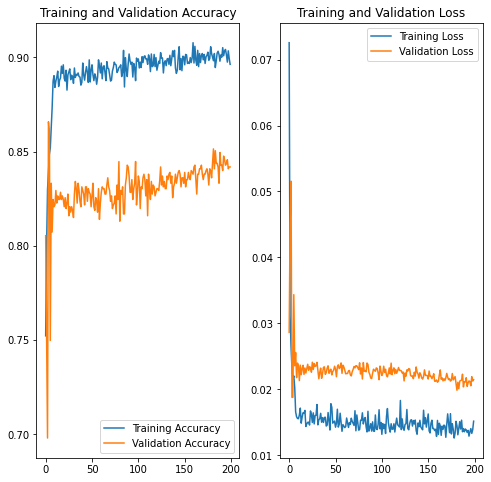

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

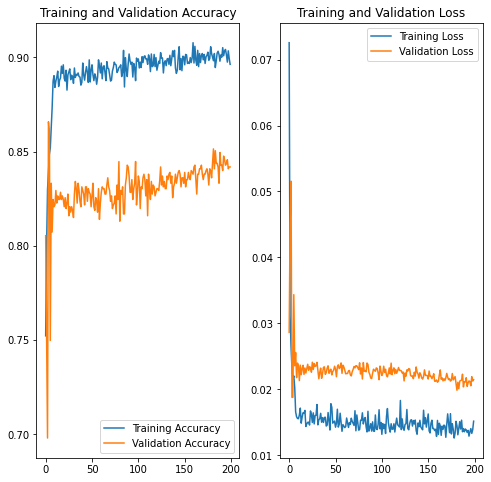

In [100]:
acc = history1['accuracy']
val_acc = history1['val_accuracy']

loss = history1['loss']
val_loss = history1['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./chest_xray/chest_xray/test/',
    labels='inferred',
    batch_size=1,
#     seed=123,
#     subset='training',
#     validation_split=0.2
    image_size=(img_height,img_width)
)

Found 624 files belonging to 2 classes.


In [25]:
test_ds = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_y = np.concatenate([y for x, y in test_ds], axis=0)

In [26]:
eval_history = model.evaluate(
    test_ds,
    batch_size=1,
)


624/624 [==============================] - 19s 29ms/step - loss: 0.0276 - tp: 328.0000 - fp: 13.0000 - tn: 221.0000 - fn: 62.0000 - accuracy: 0.8798 - precision: 0.9619 - recall: 0.8410 - auc: 0.9660 - prc: 0.9727


In [27]:
# test_y_pred = model.predict(test_ds,batch_size=1)
# test_y_pred

In [28]:
# matrix = confusion_matrix(test_y, test_y_pred.argmax())


# titles_options = [("Confusion matrix, without normalization", None),
#                   ("Normalized confusion matrix", 'true')]
# for title, normalize in titles_options:
# #     disp = plot_confusion_matrix(model,test_y,test_y_pred,
# #                                  display_labels=class_names,
# #                                  cmap=plt.cm.Blues,
# #                                  normalize=normalize)
#     disp.ax_.set_title(title)

#     print(title)
#     print(disp.confusion_matrix)

# plt.show()

In [29]:
eval_pneumonia = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./chest_xray/chest_xray/test_val/preumonia',
    labels='inferred',
    batch_size=1,
    image_size=(img_height,img_width)
)

Found 390 files belonging to 2 classes.


In [30]:
eval_pn = eval_pneumonia.cache().prefetch(buffer_size=AUTOTUNE)

In [31]:
model.evaluate(
    eval_pn,
    batch_size=1,
)

390/390 [==============================] - 11s 28ms/step - loss: 0.0211 - tp: 328.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 62.0000 - accuracy: 0.8410 - precision: 1.0000 - recall: 0.8410 - auc: 0.0000e+00 - prc: 1.0000


[0.02113077975809574,
 328.0,
 0.0,
 0.0,
 62.0,
 0.8410256505012512,
 1.0,
 0.8410256505012512,
 0.0,
 1.0]

In [32]:
eval_normal = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./chest_xray/chest_xray/test_val/normal/',
    labels='inferred',
    batch_size=1,
    image_size=(img_height,img_width)
)

Found 234 files belonging to 2 classes.


In [33]:
eval_nr = eval_normal.cache().prefetch(buffer_size=AUTOTUNE)

In [34]:
model.evaluate(
    eval_nr,
    batch_size=1,
)

234/234 [==============================] - 7s 29ms/step - loss: 0.0383 - tp: 0.0000e+00 - fp: 13.0000 - tn: 221.0000 - fn: 0.0000e+00 - accuracy: 0.9444 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00


[0.038347672671079636,
 0.0,
 13.0,
 221.0,
 0.0,
 0.9444444179534912,
 0.0,
 0.0,
 0.0,
 0.0]

In [36]:
# model.save_weights('./models/X-RAYFocalLossAdam50steps')
# model.save('models_arch/Dense121FocalLossAdam88perc')

INFO:tensorflow:Assets written to: models_arch/Dense121FocalLossAdam88perc\assets


In [38]:
model.save('./models/Dense121FocalLossAdam89perc')

INFO:tensorflow:Assets written to: ./models/Dense121FocalLossAdam89perc\assets


In [40]:
new_model = build_model_densenet()
new_model.compile(
    optimizer='adam',
#     loss='binary_crossentropy',
#     loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=0.2,gamma=2.0),
    loss=focal_loss_custom(gamma=2.0,alpha=0.2),
    metrics=METRICS
)
new_model.load_weights('./models/Dense121FocalLossAdam89perc/')

In [46]:
model_accuracy = new_model.evaluate(
    test_ds,
    batch_size=1
)


624/624 [==============================] - 18s 29ms/step - loss: 0.0276 - tp: 328.0000 - fp: 13.0000 - tn: 221.0000 - fn: 62.0000 - accuracy: 0.8798 - precision: 0.9619 - recall: 0.8410 - auc: 0.9660 - prc: 0.9727


In [51]:
TP = model_accuracy[1]
FP = model_accuracy[2]
TN = model_accuracy[3]
FN = model_accuracy[4]
model_accuracy


[0.027587126940488815,
 328.0,
 13.0,
 221.0,
 62.0,
 0.879807710647583,
 0.9618768095970154,
 0.8410256505012512,
 0.9660366177558899,
 0.9727238416671753]

In [52]:
print("Confusion Matrix : ")
print(f"[{TP}] [{FP}]")
print(f"[{FN}] [{TN}]")

Confusion Matrix : 
[328.0] [13.0]
[62.0] [221.0]


[[328.0, 13.0], [62.0, 221.0]]


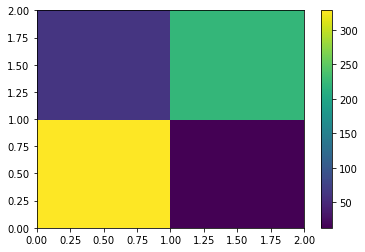

In [77]:
data = [[TP, FP],[FN, TN]]
print(data)
heatmap = plt.pcolor(data)
plt.colorbar(heatmap)
plt.show()

<AxesSubplot:>

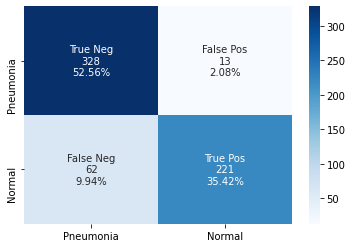

In [88]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                np.array(data).flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     np.array(data).flatten()/np.sum(data)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
categories = ['Zero' , 'One']
sns.heatmap(data, annot=labels, fmt='', cmap='Blues',xticklabels=['Pneumonia','Normal'],yticklabels=['Pneumonia','Normal'])

# ax = sns.heatmap(data/np.sum(data), annot=True, fmt=".2%",cmap='Blues',xticklabels=['P','N'],yticklabels=['P','N'])